# Mars image recognition

#### Force tensorflow to use cpu cus 4 gb gpu vram is not enougth for some reason

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#### Includes

In [2]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

#### Load data from files

In [3]:
data_folder = '../data/hirise-map-proj-v3_2/'

In [73]:
labels_names = [
    'other',
    'crater',
    'dark dune',
    'slope streak',
    'bright dune',
    'impact ejecta',
    'swiss cheese',
    'spider'
]

In [6]:
def extract_metadata() -> pd.DataFrame:
    images_and_labels = None
    with open(data_folder + 'labels-map-proj_v3_2_train_val_test.txt',
              'r') as f:
        images_and_labels = f.readlines()
    images_and_labels = pd.DataFrame(images_and_labels).replace(
        '\n', '', regex=True)[0].str.split(' ', expand=True)
    images_and_labels.rename(columns={
        0: 'file_name',
        1: 'label',
        2: 'type'
    },
                             inplace=True)
    return images_and_labels

In [7]:
metadata = extract_metadata()

In [8]:
train_data = metadata[metadata['type'] == 'train']
test_data = metadata[metadata['type'] == 'test']
val_data = metadata[metadata['type'] == 'val']

# TODO: Clean the data a bit - there is a lot of unknown object in the data that makes the model think that almost anything is unknown

In [9]:
def image_to_np(image: pd.Series) -> np.array:
    return np.asarray(
        PIL.Image.open(data_folder + 'map-proj-v3_2/' + image['file_name']))

In [10]:
def get_data(data: pd.DataFrame) -> tuple:
    labels = data['label']
    data = data.apply(image_to_np, axis=1)
    return np.stack(data.to_numpy()), np.stack(labels.to_numpy()).astype(float)

In [11]:
train_data, train_labels = get_data(train_data)
test_data, test_labels = get_data(test_data)
val_data, val_labels = get_data(val_data)

#### Train the model

In [10]:
model = models.Sequential()
model.add(
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(227, 227, 1)))
model.add(layers.MaxPool2D((3, 3)))
model.add(
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(227, 227, 1)))
model.add(layers.Dropout(.3))
model.add(layers.Flatten())
model.add(layers.Dense(8))

2022-04-04 00:46:44.424846: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-04 00:46:44.424880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ArchPC
2022-04-04 00:46:44.424885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ArchPC
2022-04-04 00:46:44.424952: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.54.0
2022-04-04 00:46:44.424969: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.54.0
2022-04-04 00:46:44.424972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.54.0
2022-04-04 00:46:44.425385: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 16)        2320      
                                                                 
 dropout (Dropout)           (None, 73, 73, 16)        0         
                                                                 
 flatten (Flatten)           (None, 85264)             0         
                                                                 
 dense (Dense)               (None, 8)                 682120    
                                                        

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=5, validation_data=(val_data, val_labels))

Epoch 1/5


2022-04-04 00:47:05.941130: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2630967682 exceeds 10% of free system memory.


1596/1596 [==============================] - ETA: 0s - loss: 2.2695 - accuracy: 0.7877

2022-04-04 00:52:00.994698: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 770822311 exceeds 10% of free system memory.


1596/1596 [==============================] - 311s 195ms/step - loss: 2.2695 - accuracy: 0.7877 - val_loss: 1.0193 - val_accuracy: 0.7521
Epoch 2/5
1596/1596 [==============================] - 295s 185ms/step - loss: 0.6771 - accuracy: 0.8254 - val_loss: 1.0591 - val_accuracy: 0.7577
Epoch 3/5
1596/1596 [==============================] - 305s 191ms/step - loss: 0.5402 - accuracy: 0.8496 - val_loss: 1.1334 - val_accuracy: 0.7536
Epoch 4/5
1596/1596 [==============================] - 311s 195ms/step - loss: 0.4351 - accuracy: 0.8739 - val_loss: 1.5364 - val_accuracy: 0.7518
Epoch 5/5
1596/1596 [==============================] - 305s 191ms/step - loss: 0.3783 - accuracy: 0.8898 - val_loss: 1.7228 - val_accuracy: 0.7403


#### Check model accuracy and performance

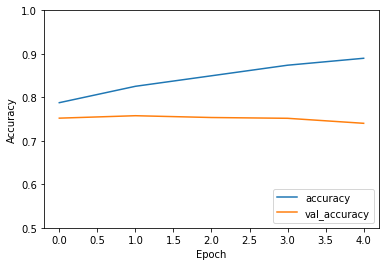

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [12]:
val_loss, val_acc = model.evaluate(val_data, val_labels, verbose=2)
print(val_acc)

468/468 - 17s - loss: 1.7228 - accuracy: 0.7403 - 17s/epoch - 37ms/step
0.740290105342865


In [14]:
val_pred = model.predict(val_data)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [19]:
val_pred_index = val_pred.argmax(axis=1)

In [37]:
val_wrong_pred = np.where(val_pred_index != val_labels)[0]

In [102]:
val_pred_not_unknown = np.where(val_pred_index != 0)[0]

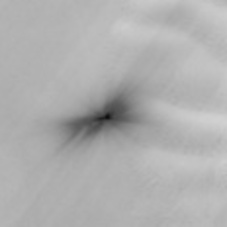

predicted:  other
actual:  impact ejecta


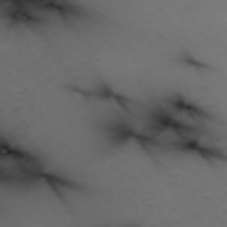

predicted:  other
actual:  spider


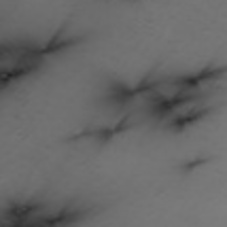

predicted:  other
actual:  spider


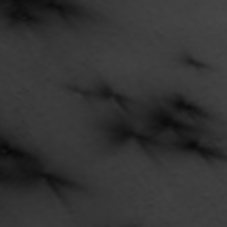

predicted:  other
actual:  spider


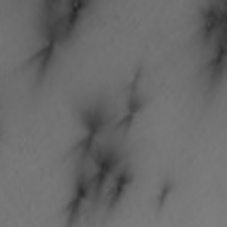

predicted:  other
actual:  spider


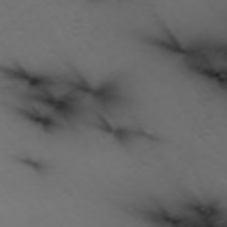

predicted:  other
actual:  spider


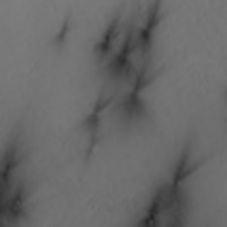

predicted:  other
actual:  spider


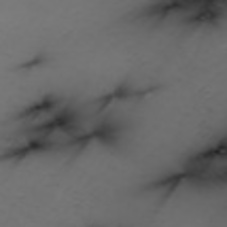

predicted:  other
actual:  spider


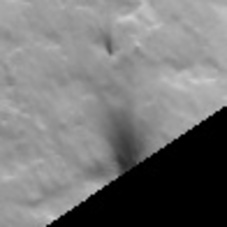

predicted:  other
actual:  spider


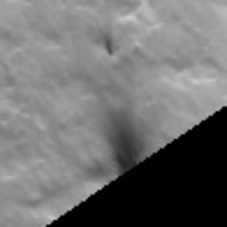

predicted:  other
actual:  spider


In [104]:
i = 20
for image in val_data[val_wrong_pred[20:30]]:
    display(PIL.Image.fromarray(image))
    print('predicted: ', labels_names[int(val_pred_index[val_wrong_pred[i]])])
    print('actual: ', labels_names[int(val_labels[val_wrong_pred[i]])])
    i += 1

In [116]:
[np.where(val_labels == x)[0].shape[0] - np.where(val_pred_index == x)[0].shape[0] for x in range(8)]

[-2222, 556, 108, 591, -134, 215, 574, 312]

In [13]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print(test_acc)

57/57 - 2s - loss: 1.3606 - accuracy: 0.8137 - 2s/epoch - 36ms/step
0.8137200474739075


#### Save model 

In [17]:
model.save('./model')

2022-04-04 01:19:57.852058: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model/assets


#### Load model

In [4]:
model = models.load_model('./model')

2022-04-04 01:20:38.907512: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-04 01:20:38.907540: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ArchPC
2022-04-04 01:20:38.907544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ArchPC
2022-04-04 01:20:38.907603: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.54.0
2022-04-04 01:20:38.907619: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.54.0
2022-04-04 01:20:38.907622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.54.0
2022-04-04 01:20:38.908015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf